## Bounding Box model

The concept and data is from this kaggle kernel: [Bounding Box Model](https://www.kaggle.com/martinpiotte/bounding-box-model)

Also from this notebook: [github](https://github.com/radekosmulski/whale/blob/master/fluke_detection_redux.ipynb)

The idea is standardize the image focus and to make it easier for the classification model to recognize whale id. The data provided was manually created by placing landmarks on the whale tail and using the maximum value of them to create the the cropping location. 

There are 1200 bounding box samples. The data is not from this competition but from the [playground](https://www.kaggle.com/c/whale-categorization-playground) 

Make sure to make to upgrade your fastai. I was using 1.0.38 & 1.0.39 which was giving errors when creating the databunch until it was update to 1.0.41. error: ' can't convert np.ndarray of type numpy.object_.'

In [1]:
import fastai
from fastai import *
from fastai.vision import *
print(f'fastai version: {fastai.__version__}')
print(f'torch version: {torch.__version__}')

verbose = True  # print out extra details?

# import matplotlib.patches.Path
from matplotlib.patches import Rectangle
%matplotlib inline

import json
import warnings
warnings.filterwarnings('ignore')
# to stop fastai from printing out "UserWarning: Tensor is int32: upgrading to int64;"

fastai version: 1.0.41
torch version: 1.0.0


In [2]:
# global setting
data_fp = Path('data')
data_train = data_fp/'train'
data_playground = data_fp/'train_playground'
data_test = data_fp/'train_playground'  # this should be change to train for the cropping
crop_fp = data_fp/'cropping.txt'

In [3]:
bs = 16
num_workers = 3  # set to zero when using kaggle kernel. It crashing the kernel if not
sz = 224 ## resize images

## Look into the cropping dataset

In [4]:
with open(crop_fp, 'rt') as f:
    crop_ls = [r.split(',') for r in f.read().split('\n') if len(r.split(',')) > 1]

In [5]:
crop_data = [(img, [(int(coords[i]), int(coords[i+1])) for i in range(0, len(coords), 2)]) 
                                                         for img, *coords in crop_ls]

set([len(r[1]) for r in crop_data])

{4, 5, 6, 7, 8, 9, 10, 11}

There are varying number of point pairs for each image ranging from 4 to 11 points. To obtain a bounding box, one need to get the min, max value of the x and y axis. 

Each step converting data into the right format to use
```python
    text file: "image_filename, x1, y1, x2, x3, ... \n .....]
    crop_ls: [image_filename, x1, y1, x2, x3, ...]
    crop_data: [image_filename, [(x1, y1), (x2, y2), ..]]
```

In [6]:
crop_data[0]

('88532e70.jpg',
 [(195, 293),
  (269, 115),
  (868, 158),
  (888, 170),
  (641, 496),
  (512, 546),
  (321, 524)])

In [7]:
def get_bbox(coords):
    x, y = [x for x,_ in coords], [y for _,y in coords]
    xmin, xmax= min(x), max(x)
    ymin, ymax = min(y), max(y)
    # lower left corner, width and height
    return xmin, ymin, xmax-xmin, ymax-ymin

def draw_bbox(box):
    return Rectangle((box[0], box[1]), box[2], box[3],
                     linewidth=1, edgecolor='r', facecolor='none')

def img_bbox(data):
    img = PIL.Image.open(data_playground/data[0])
    _, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    ax.axis('off')
    ax.scatter([x for x,_ in data[1]], [y for _,y in data[1]], marker='o', c='r')
    ax.add_patch(draw_bbox(get_bbox(data[1])))
    ax.set_title(data[0])
    plt.show()

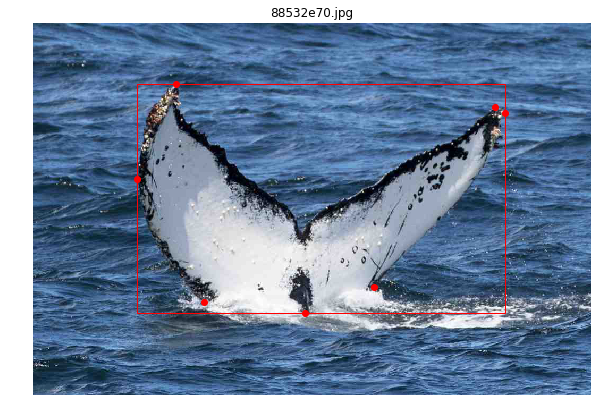

In [8]:
# bbox is created from the landmarks
img_bbox(crop_data[0])

## Convert data into Coco dataset format and then to fastai format


**Coco format**
```json
{
    "categories": [
        {"id": 0, "name": "whale"},
        {"id": 1, "name": "placeholder"}
    ],
    "images": [
        {"id": 1000, "file_name": "whale1.jpg"},
        {"id": 1001, "file_name": "whale2.jpg"}
    ],
    "annotations": [
        {"image_id": 1000, "bbox": [x, y, width, height], "category_id": 0},
        {"image_id": 1001, "bbox": [x, y, width, height], "category_id": 0}
    ]
}
```

**Fastai Format** for multiple objects in an image
```python
[
    [image_fn, image_fn],
    [[
        [[[top, left, bottom, right], 
          [[top, left, bottom, right]], 
         ['whale', 'whale']],
        [[[[top, left, bottom, right], 
          [[top, left, bottom, right]], 
         ['whale', 'whale']]
    ]]  
]
```

In [9]:
images, annotations = [], []
for i, v in enumerate(crop_data, start=1000):
    images.append({"id": i, "file_name": v[0]})
    annotations.append({"image_id": i, "bbox": get_bbox(v[1]), "category_id": 0})

categories = [{"id": 0, "name": "whale"}]

coco_whale = {"categories": categories,
              "images": images,
              "annotations": annotations}

with open("data/coco_whale.json", "w+") as f:
    json.dump(obj=coco_whale, fp=f, indent=4)

In [10]:
del images, annotations, categories, coco_whale, i, v, crop_data, crop_fp, crop_ls

## Testing that the conversion was done corrected

In [4]:
tmp_images, tmp_lbl_bbox = get_annotations('data/coco_whale.json')
len(tmp_images)

1200

coco_dataset format is (x, y, width, height)

fastai expect (y_upper_left, x_upper_left, y_lower_right, x_lower_right) with the origin in the upper left hand corner of the image. 

BBox coords: [[115, 195, 546, 888]]


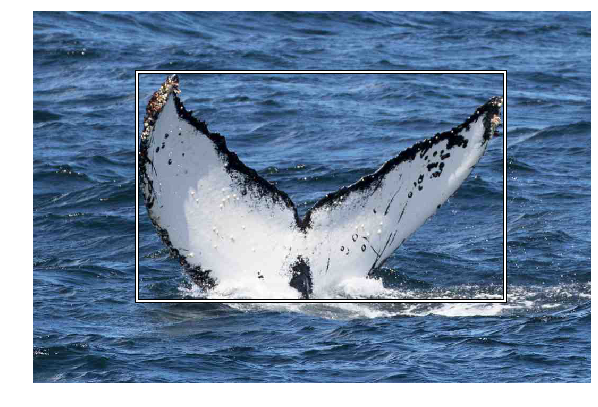

In [5]:
img = open_image(Path('data/train_playground')/tmp_images[0])
print(f'BBox coords: {tmp_lbl_bbox[0][0]}')
bbox = ImageBBox.create(*img.size, tmp_lbl_bbox[0][0])
img.show(y=bbox, figsize=(10,10))

In [6]:
del tmp_images, tmp_lbl_bbox, img, bbox

## Create DataBunch with Coco Format

In [15]:
images, lbl_bbox = get_annotations('data/coco_whale.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o: img2bbox[Path(o).name]

In [16]:
tfm = get_transforms(flip_vert=False, 
                     # doesn't make sense to have upside down tails
                     max_rotate=0.3,
                      # rotating too much will cause the bbox to be super large and not accurate
                     max_zoom=1)
                     # remove zooming 
    
if verbose: # show the list of transformation
    for i in tfm:
        for j in i: print(j)
        print("\n")

RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True)
RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True)
RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True)
RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-0.3, 0.3)}, p=0.75, resolved={}, do_run=True, is_random=True)
RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True)
RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)


RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)




In [17]:
# class OneObjectCategoryList(ObjectCategoryList):
#     def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.zeros(1).long().unsqueeze(0)]
# class ObjectItemListOne(ImageItemList):
#     _label_cls,_square_show_res = OneObjectCategoryList,False

# It might just be because windows is not supported that is why i am getting the [Errno 32] Broken pipe
# when ever I do data.show_batch

In [48]:
data = (ObjectItemList.from_df(pd.DataFrame(data=images), path=data_fp, folder='train_playground')
        .random_split_by_pct(seed=52)                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .add_test_folder('test')  # TODO change to actual competition data
        .transform(get_transforms(), 
                   tfm_y= True, 
                   size=sz, 
                   resize_method=ResizeMethod.SQUISH,
                   padding_mode='border')
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=bs, collate_fn=bb_pad_collate, num_workers=num_workers)   
        #Finally we convert to a DataBunch and we use bb_pad_collate
        .normalize(imagenet_stats))

In [50]:
data.test_ds.tfm_y = False  # test set has no y value so no transformation for it

In [51]:
len(data.test_ds)

7960

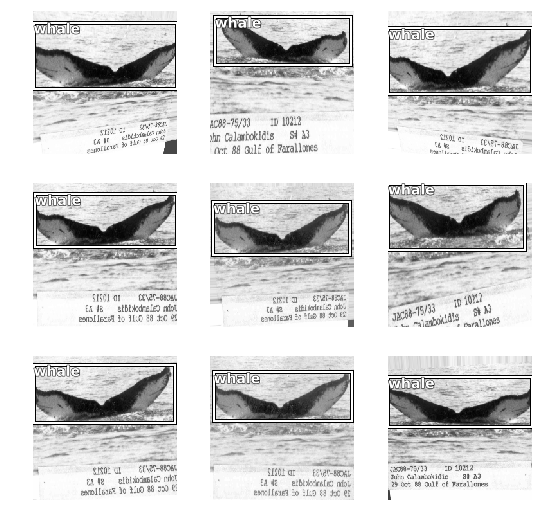

In [22]:
idx = 65
fig, axes = plt.subplots(3,3, figsize=(9,9))
for i, ax in enumerate(axes.flat):
    img = data.train_ds[idx]
    # image is augmented each time it is retrived
    img[0].show(y=img[1], ax=ax)

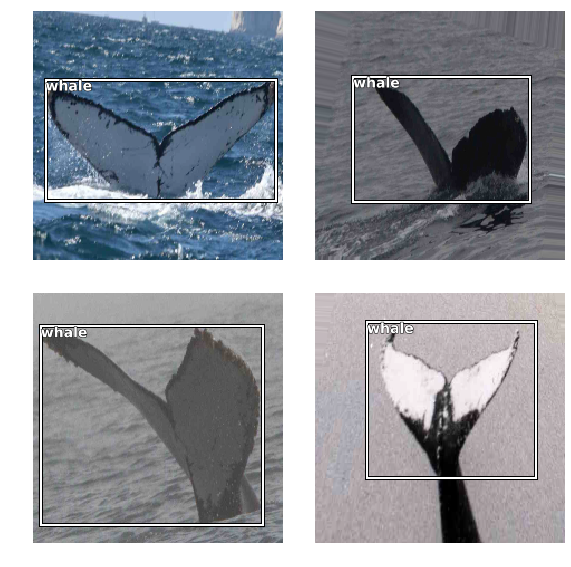

In [23]:
data.show_batch(rows=2)

## Training

First attempt with resnet18 with a simple custom head of nn.Sequential(Flatten(), nn.Linear(25088,4)) did not have good result: the xaxis are out of the range [-1,1] and are consistently around -2.8 and 1.5. the y axis is two narrow. I believe the reason is because the bbox for the xaxis is consistently at the edge of the image and so being outside is reasonable.

Second attempt:
TODO:
* Increase the complexity of the custom head with some non-linear features
* new loss function
* new metrics
* more augmentation
* Use a larger resnet
* increase bs
* using  fit_one_cycle instead of fit


In [26]:
# L1Loss is used instead of MSE is because MSE penalize mistake more than it should 
def loss_func(preds, targs, class_idx, **kwargs):
    return nn.L1Loss()(preds, targs.squeeze())

In [27]:
head_reg4 = nn.Sequential(
    Flatten(), 
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4))
    # Maybe add nn.tanh since the values are [-1,1]
learn = create_cnn(data=data, arch=models.resnet18, pretrained=True, custom_head=head_reg4,
#                    model_dir = '/tmp/models'  ## For kaggle kernel 
                  )
learn.loss_func = loss_func
# change the loss function??

In [22]:
if verbose: print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [16, 64, 112, 112]   9408       False     
______________________________________________________________________
BatchNorm2d          [16, 64, 112, 112]   128        True      
______________________________________________________________________
ReLU                 [16, 64, 112, 112]   0          False     
______________________________________________________________________
MaxPool2d            [16, 64, 56, 56]     0          False     
______________________________________________________________________
Conv2d               [16, 64, 56, 56]     36864      False     
______________________________________________________________________
BatchNorm2d          [16, 64, 56, 56]     128        True      
______________________________________________________________________
ReLU                 [16, 64, 56, 56]     0          False     
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


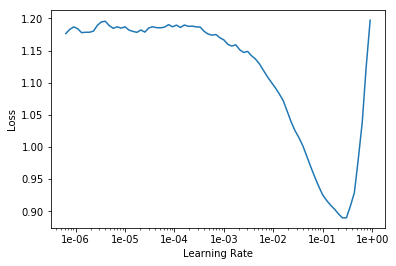

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(15, pct_start=0.5)

epoch,train_loss,valid_loss
1,1.051883,0.886009
2,0.920388,0.625049
3,0.704496,0.312130
4,0.491523,0.198576
5,0.312068,0.105413
6,0.201959,0.093276
7,0.157301,0.083838
8,0.142830,0.097188
9,0.130745,0.096560
10,0.123784,0.088695


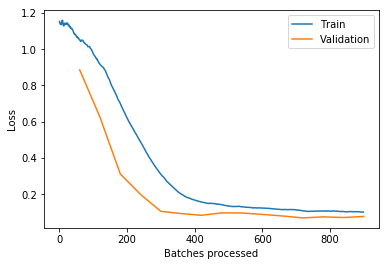

In [30]:
learn.recorder.plot_losses()

In [31]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


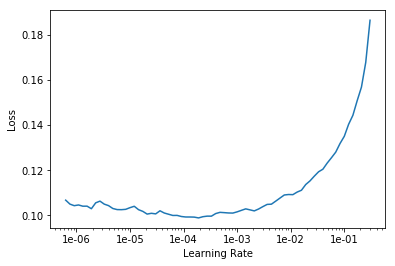

In [32]:
learn.lr_find()
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(15, max_lr = slice(0.001, 0.001/5), pct_start=0.5)

epoch,train_loss,valid_loss
1,0.100495,0.071610
2,0.098035,0.063401
3,0.094458,0.067800
4,0.094738,0.092415
5,0.095978,0.097807
6,0.095806,0.071436
7,0.091595,0.054366
8,0.093835,0.057703
9,0.093333,0.068546
10,0.089942,0.056761


In [34]:
learn.save('bounding-box-model', return_path=True)

WindowsPath('data/models/bounding-box-model.pth')

## Check Validation Set

In [35]:
# implement different loss function like detn_l1
    # IoU??
preds, targs = learn.get_preds(ds_type=DatasetType.Valid)
targs = targs.squeeze()  # fastai outputs multiple objects per image but we only have 1
# making sure the preds values are within the picture
preds = torch.clamp(preds, -1,1)

In [36]:
# check to see what the output looks like
if verbose:
    print(preds.shape, targs.shape)
    print(preds[:2])
    print(targs[:2])

torch.Size([240, 4]) torch.Size([240, 4])
tensor([[-0.5403, -0.9581,  0.2887,  0.9460],
        [-0.7677, -0.9580,  0.6303,  0.9597]])
tensor([[-0.4840, -0.9943,  0.2640,  0.9772],
        [-0.7967, -0.9657,  0.5500,  0.9733]])


target: tensor([-0.7252, -0.9048,  0.5267,  0.9429]), pred: tensor([-0.8037, -0.9807,  0.5814,  0.9797])
target: tensor([-0.9567, -0.9771,  0.9177,  0.9943]), pred: tensor([-0.9627, -0.9697,  0.9543,  0.9718])
target: tensor([-0.9387, -0.9943,  0.8942,  0.9829]), pred: tensor([-0.9587, -0.9904,  0.9351,  0.9963])
target: tensor([-0.5914, -0.8019,  0.2543,  0.8210]), pred: tensor([-0.5816, -0.8340,  0.3144,  0.8411])
target: tensor([-0.9644, -0.9829,  0.8677,  0.9593]), pred: tensor([-0.9531, -0.9803,  0.9167,  0.9787])
target: tensor([-0.9644, -0.9829,  0.8677,  0.9593]), pred: tensor([-0.9531, -0.9803,  0.9167,  0.9787])
target: tensor([-0.8508, -0.8743, -0.0254,  0.8571]), pred: tensor([-0.9178, -0.9471,  0.0962,  0.9354])
target: tensor([-0.8224, -0.9803,  0.8618,  0.9634]), pred: tensor([-0.9252, -0.9934,  0.8825,  0.9932])
target: tensor([-0.7657, -0.7657,  0.3971,  0.8438]), pred: tensor([-0.8091, -0.8816,  0.4313,  0.8863])
target: tensor([-0.8602, -0.9497,  0.8237,  0.9465]), p

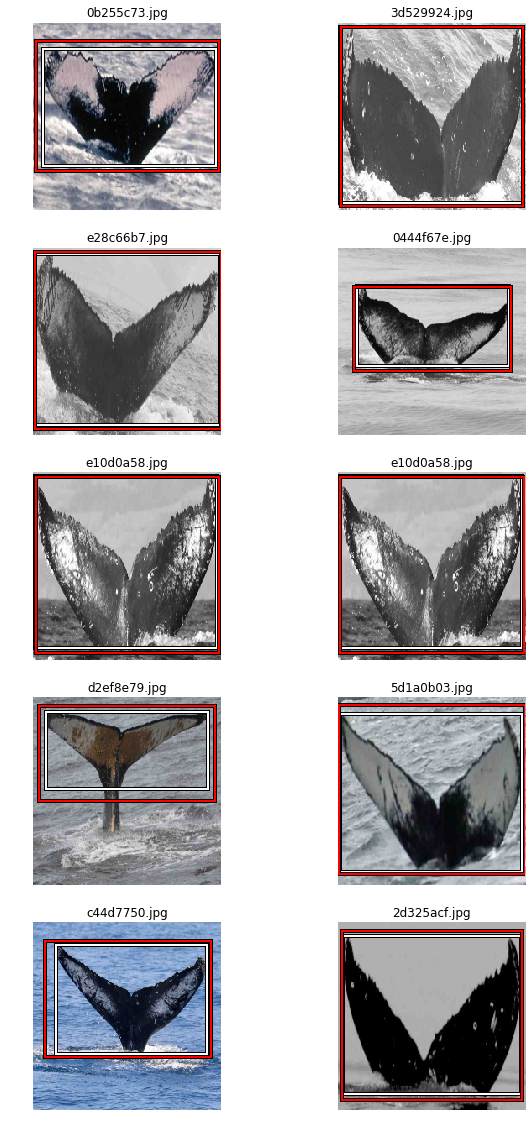

In [37]:
np.random.seed(24)
n = 10  # look at n samples, must be even
idxs = np.random.randint(0,len(data.valid_ds), size=n)
_, axes = plt.subplots(nrows=n//2, ncols=2, figsize = (n, n*2))
for i, ax in zip(idxs, axes.flat):
    img = data.valid_ds[i][0].data  # image resize after data is called else original image size
    img_name = Path(data.valid_ds.items[i]).name
    img_size = img.shape[1:]
    targ, pred = targs[i], preds[i]
    if verbose: print(f'target: {targ}, pred: {pred}')
    Image(img).show(ax=ax,
                    # target is white
                     y=ImageBBox.create(*img_size, 
                                        bboxes=targ.unsqueeze(0),
                                        scale=False),
                    title=img_name)
    # Prediction is red
    ImageBBox.create(*img_size, 
                     bboxes=pred.unsqueeze(0),
                     scale=False).show(ax=ax, color='red')

In [2]:
# TODO: Display the ones that are most way off. 
## use the custom loss function

## Crop image based on pred (not ready)

In [52]:
learn.data = data

In [126]:
cropped_fp = data_fp/"train-crop-224"
cropped_fp.mkdir(parents=True, exist_ok=True) # save crop images to reduce computation

In [132]:
test_fp = data_fp/'train_playground'
files = get_files(test_fp)

In [54]:
res = learn.get_preds(ds_type=DatasetType.Test)

TypeError: Traceback (most recent call last):
  File "C:\Users\boki\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "C:\Users\boki\Anaconda3\lib\site-packages\fastai\vision\data.py", line 43, in bb_pad_collate
    max_len = max([len(s[1].data[1]) for s in samples])
  File "C:\Users\boki\Anaconda3\lib\site-packages\fastai\vision\data.py", line 43, in <listcomp>
    max_len = max([len(s[1].data[1]) for s in samples])
TypeError: 'int' object is not subscriptable


In [56]:
%debug

> c:\users\boki\anaconda3\lib\site-packages\torch\utils\data\dataloader.py(658)_process_next_batch()
    656         self._put_indices()
    657         if isinstance(batch, ExceptionWrapper):
--> 658             raise batch.exc_type(batch.exc_msg)
    659         return batch
    660 



ipdb>  pbd s


*** SyntaxError: invalid syntax


ipdb>  type(batch)


<class 'torch.utils.data.dataloader.ExceptionWrapper'>


ipdb>  batch.exc_msg


'Traceback (most recent call last):\n  File "C:\\Users\\boki\\Anaconda3\\lib\\site-packages\\torch\\utils\\data\\dataloader.py", line 138, in _worker_loop\n    samples = collate_fn([dataset[i] for i in batch_indices])\n  File "C:\\Users\\boki\\Anaconda3\\lib\\site-packages\\fastai\\vision\\data.py", line 43, in bb_pad_collate\n    max_len = max([len(s[1].data[1]) for s in samples])\n  File "C:\\Users\\boki\\Anaconda3\\lib\\site-packages\\fastai\\vision\\data.py", line 43, in <listcomp>\n    max_len = max([len(s[1].data[1]) for s in samples])\nTypeError: \'int\' object is not subscriptable\n'


ipdb>  type(self)


<class 'torch.utils.data.dataloader._DataLoaderIter'>


ipdb>  batch_indices


*** NameError: name 'batch_indices' is not defined


ipdb>  h



Documented commands (type help <topic>):
EOF    cl         disable  interact  next    psource  rv         unt   
a      clear      display  j         p       q        s          until 
alias  commands   down     jump      pdef    quit     source     up    
args   condition  enable   l         pdoc    r        step       w     
b      cont       exit     list      pfile   restart  tbreak     whatis
break  continue   h        ll        pinfo   return   u          where 
bt     d          help     longlist  pinfo2  retval   unalias  
c      debug      ignore   n         pp      run      undisplay

Miscellaneous help topics:
exec  pdb



ipdb>  jump


*** The 'jump' command requires a line number


ipdb>  jump 637


*** Jump failed: f_lineno can only be set by a trace function


ipdb>  jump 1


*** Jump failed: f_lineno can only be set by a trace function


ipdb>  jump 138


*** Jump failed: f_lineno can only be set by a trace function


ipdb>  a


self = <torch.utils.data.dataloader._DataLoaderIter object at 0x000002790BEE2D30>
batch = <torch.utils.data.dataloader.ExceptionWrapper object at 0x000002790BEFCE10>


ipdb>  type(batch)


<class 'torch.utils.data.dataloader.ExceptionWrapper'>


ipdb>  self._put_indices()


*** AssertionError


ipdb>  self.__dict__


{'dataset': LabelList
y: EmptyLabelList (7960 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ObjectItemList (7960 items)
[Image (3, 522, 1050), Image (3, 390, 683), Image (3, 700, 1050), Image (3, 324, 1050), Image (3, 457, 686)]...
Path: data, 'collate_fn': <function bb_pad_collate at 0x0000027907B66AE8>, 'batch_sampler': <torch.utils.data.sampler.BatchSampler object at 0x000002790BEF2588>, 'num_workers': 3, 'pin_memory': False, 'timeout': 0, 'sample_iter': <generator object BatchSampler.__iter__ at 0x000002795F25A318>, 'worker_init_fn': None, 'worker_queue_idx': 1, 'worker_result_queue': <multiprocessing.queues.Queue object at 0x000002790BEE2A90>, 'batches_outstanding': 6, 'worker_pids_set': True, 'shutdown': False, 'send_idx': 7, 'rcvd_idx': 1, 'reorder_dict': {}, 'done_event': <multiprocessing.synchronize.Event object at 0x000002790BEE2FD0>, 'index_queues': [<multiprocessing.queues.Queue object at 0x000002790A3BBE80>, <multiprocessing.queues.

ipdb>  type(self)


<class 'torch.utils.data.dataloader._DataLoaderIter'>


ipdb>  self.num_workers


3


ipdb>  self.batches_outstanding


6


ipdb>  next(self.sample_iter)


In [60]:
tmp = iter(learn.data.test_dl.batch_sampler)

In [66]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [68]:
learn.pred_batch(ds_type=DatasetType.Test)

TypeError: Traceback (most recent call last):
  File "C:\Users\boki\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "C:\Users\boki\Anaconda3\lib\site-packages\fastai\vision\data.py", line 43, in bb_pad_collate
    max_len = max([len(s[1].data[1]) for s in samples])
  File "C:\Users\boki\Anaconda3\lib\site-packages\fastai\vision\data.py", line 43, in <listcomp>
    max_len = max([len(s[1].data[1]) for s in samples])
TypeError: 'int' object is not subscriptable


In [67]:
learn.pred_batch??

Signature:
learn.pred_batch(
    ['ds_type: fastai.basic_data.DatasetType = <DatasetType.Valid: 2>', 'batch: Tuple = None', 'reconstruct: bool = False'],
) -> List[torch.Tensor]
Source:   
    def pred_batch(self, ds_type:DatasetType=DatasetType.Valid, batch:Tuple=None, reconstruct:bool=False) -> List[Tensor]:
        "Return output of the model on one batch from `ds_type` dataset."
        if batch is not None: xb,yb = batch
        else: xb,yb = self.data.one_batch(ds_type, detach=False, denorm=False)
        cb_handler = CallbackHandler(self.callbacks)
        xb,yb = cb_handler.on_batch_begin(xb,yb, train=False)
        preds = loss_batch(self.model.eval(), xb, yb, cb_handler=cb_handler)
        res = _loss_func2activ(self.loss_func)(preds[0])
        if not reconstruct: return res
        res = res.detach().cpu()
        ds = self.dl(ds_type).dataset
        norm = getattr(self.data, 'norm', False)
        if norm and norm.keywords.get('do_y',False):
            res = self.data.de

In [63]:
next(tmp)

[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

In [42]:
tmp = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
res = learn.get_preds(ds_type=DatasetType.Test)

In [47]:
tmp = learn.data.one_batch(DatasetType.Test)

TypeError: Traceback (most recent call last):
  File "C:\Users\boki\Anaconda3\lib\site-packages\torch\utils\data\dataloader.py", line 138, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "C:\Users\boki\Anaconda3\lib\site-packages\fastai\vision\data.py", line 43, in bb_pad_collate
    max_len = max([len(s[1].data[1]) for s in samples])
  File "C:\Users\boki\Anaconda3\lib\site-packages\fastai\vision\data.py", line 43, in <listcomp>
    max_len = max([len(s[1].data[1]) for s in samples])
TypeError: 'int' object is not subscriptable


In [131]:
cropped_fp.name

'train-crop-224'

In [65]:
img = open_image('data\\train_playground\\.\\9c855d38.jpg')

torch.Size([700, 1050])
(tensor([[-0.5000, -0.8019,  0.3257,  0.6876]]), array([1]))


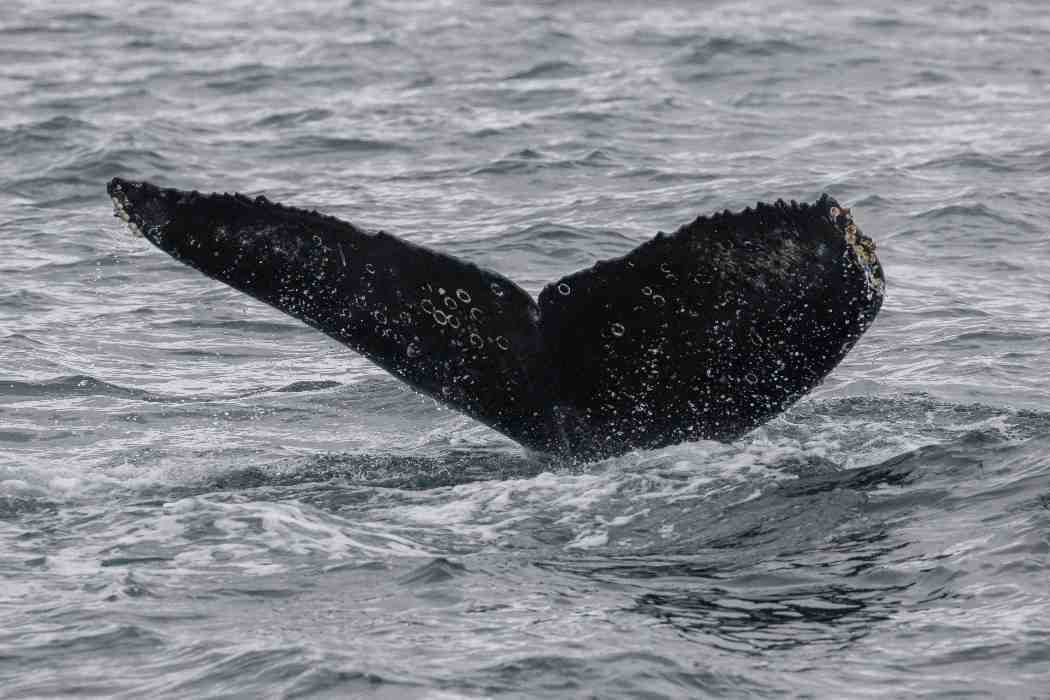

In [109]:
print(img.size)
print(bbox.data)
img

In [113]:
(bbox.data[0]+1) * torch.tensor([img.size[0]//2,img.size[1]//2]*2).float()

tensor([[175.0000, 104.0000, 464.0000, 886.0000]])

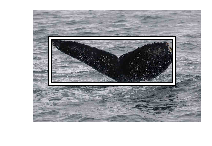

In [114]:
img.show( y=ImageBBox.create(*img.size, 
                             bboxes=(bbox.data[0]+1) * torch.tensor([img.size[0]//2,img.size[1]//2]*2).float(), 
                             scale=True) )

In [98]:
(bbox.data[0]+1).shape

torch.Size([1, 4])

In [103]:
torch.tensor([[1.,2.]]).shape

torch.Size([1, 2])

In [104]:
(bbox.data[0]+1).squeeze().unsqueeze(1) * torch.tensor([[1.,2.]]).squeeze().unsqueeze(1)

RuntimeError: The size of tensor a (4) must match the size of tensor b (2) at non-singleton dimension 0

In [78]:
torch.empty(5,3,4,1).shape

torch.Size([5, 3, 4, 1])

In [79]:
torch.empty(  3,1,1).shape

torch.Size([3, 1, 1])

torch.Size([700, 1050])


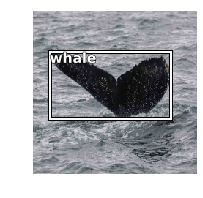

In [41]:
img, bbox = data.valid_ds[89]
print(img.size)
img.show(y=bbox)

In [56]:
print(img.data.size())

torch.Size([3, 224, 224])


In [52]:
crop_bbox = ((bbox.data[0]+1)*112).int().squeeze().numpy(); crop_bbox

array([ 56,  22, 148, 189])

Image (3, 92, 167)


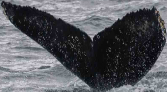

In [60]:
crop_img = Image(img.data[:, crop_bbox[0]:crop_bbox[2], crop_bbox[1]:crop_bbox[3]])
print(crop_img)
crop_img

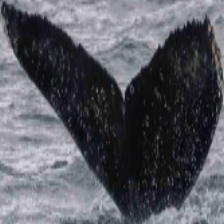

In [62]:
crop_img.resize(224)

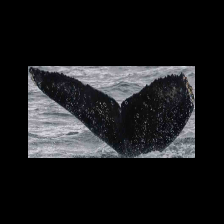

In [63]:
crop_pad(Image(img.data[:, crop_bbox[0]:crop_bbox[2], crop_bbox[1]:crop_bbox[3]]), 224, 'zeros')

In [51]:
crop_bbox[0], crop_bbox[2], crop_bbox[1],crop_bbox[3]

(tensor(56, dtype=torch.int32),
 tensor(148, dtype=torch.int32),
 tensor(22, dtype=torch.int32),
 tensor(189, dtype=torch.int32))

In [28]:
i

torch.Size([224, 224])

In [ ]:
crop_pad(img, 224, 'reflection', row_pct=, col_pct=)

In [30]:
crop_pad??  ## resize_method=ResizeMethod.PAD, padding_mode='reflection'  Do not wnat continue to squish the image

Signature:      
crop_pad(
    ['x', 'size', "padding_mode='reflection'", 'row_pct: <function uniform at 0x00000190C940BEA0> = 0.5', 'col_pct: <function uniform at 0x00000190C940BEA0> = 0.5'],
) -> fastai.vision.image.Image
Call signature:  crop_pad(*args: Any, p: float = 1.0, is_random: bool = True, **kwargs: Any) -> fastai.vision.image.Image
Type:            TfmCrop
String form:     TfmCrop (crop_pad)
File:            c:\users\boki\anaconda3\lib\site-packages\fastai\vision\transform.py
Source:         
def _crop_pad(x, size, padding_mode='reflection', row_pct:uniform = 0.5, col_pct:uniform = 0.5):
    f_crop_pad = _crop_pad_image_points if isinstance(x, ImagePoints) else _crop_pad_default
    return f_crop_pad(x, size, padding_mode, row_pct, col_pct)
Class docstring: Decorator for crop tfm funcs.
Init docstring:  Create a transform for `func` and assign it an priority `order`, attach to `Image` class.
Call docstring:  Calc now if `args` passed; else create a transform called prob `p`

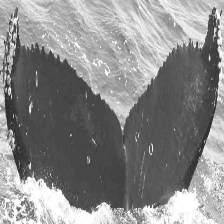

In [68]:
Image(img)

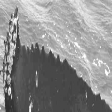

In [71]:
Image(img[:, 0:112, 0:112])

In [72]:
type(preds)

torch.Tensor

In [74]:
pd.DataFrame(data = preds.numpy()).to_csv('testing.csv')

,0,1,2,3
0,1.0,-1.0,0.491263,-1.0
1,1.0,1.0,1.000000,1.0
2,-1.0,-1.0,1.000000,-1.0
3,1.0,1.0,1.000000,-1.0
4,1.0,1.0,1.000000,1.0


In [1]:
# TODO: Export the model as well so people do not need to retrain